In [1]:

import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F


In [2]:
!wget "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"

--2026-01-20 13:57:26--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt.2’

input.txt.2         100%[===================>]   1.06M  --.-KB/s    in 0.04s   

2026-01-20 13:57:26 (29.4 MB/s) - ‘input.txt.2’ saved [1115394/1115394]



In [3]:
filename = 'input.txt'
with open(filename, 'r', encoding='utf-8') as f:
    text = f.read()

In [4]:
unk_token = '<UNK>'

all_chars = sorted(list(set(text)))


vocab_size = len(all_chars) + 1
stoi = {s:i for i, s in enumerate(all_chars)}
stoi[unk_token] = -1
itos = {i:s for s, i in stoi.items()}


print(f"Vocab size: {vocab_size}")


Vocab size: 66


In [5]:
def encode(string):
    return [stoi.get(char, stoi[unk_token]) for char in string]

def decode(encoded):
    return "".join([itos[idx] for idx in encoded])




encoded = encode('my name is peet กขค')
decode(encoded)

'my name is peet <UNK><UNK><UNK>'

In [6]:
data = encode(text)

train = data[:int(len(data)*0.9)]
test = data[int(len(data)*0.9):]


len(train), len(test)


(1003854, 111540)

In [7]:



def get_batch(data, block_size, batch_size):
    random_start_idx = torch.randint(low=0, high=len(data) - block_size, size=(batch_size, ))

    X = torch.tensor([data[idx:idx + block_size] for idx in random_start_idx])
    y = torch.tensor([data[idx:idx + block_size] for idx in random_start_idx + 1])
    return X, y






def print_example(X_train, y_train):
    print(f"Batch size: {X_train.shape[0]} | Block size: {X_train.shape[1]}")
    print(f"X shape: {X_train.shape} | y shape: {y_train.shape}\n")

    print("=" * 60)
    print(f"Training Example from Batch[0]:")
    print("=" * 60)

    for i in range(len(X_train[0])):
        context = X_train[0][:i+1].tolist()
        target = y_train[0][i].item()

        context_str = str(context).ljust(35)
        print(f"Context: {context_str} → Target: {target}")




In [8]:

class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super().__init__()  # ADDED: Initialize nn.Module

        self.weight = torch.nn.Parameter(torch.randn((vocab_size, embed_dim)) * 0.02)

    # BEFORE: def __call__(self, x)
    # AFTER: def forward(self, x)
    def forward(self, x):
        return self.weight[x]

    # REMOVED: def parameters(self)


class PositionEmbedding(nn.Module):
    def __init__(self, block_size, embed_dim):
        super().__init__()  # ADDED: Initialize nn.Module
        self.weight = torch.nn.Parameter(torch.randn((block_size, embed_dim)) * 0.02)

    def forward(self, x):
        # BEFORE: return self.Weight[torch.arange(x.shape[1])]
        # AFTER: Ensure arange is on same device as weight for GPU compatibility
        device = self.weight.device
        return self.weight[torch.arange(x.shape[1], device=device)]

    # REMOVED: def parameters(self)


# ============================================
# BEFORE: class Linear (no nn.Module inheritance)
# AFTER: Inherit from nn.Module
# ============================================
class Linear(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super().__init__()  # ADDED: Initialize nn.Module
        std = in_features ** -0.5
        self.weight = torch.nn.Parameter(torch.randn((in_features, out_features)) * std)

        if bias:
            self.bias = torch.nn.Parameter(torch.zeros(out_features))
        else:
            self.register_parameter('bias', None)  # ADDED: Proper parameter registration

    def forward(self, x):
        out = x @ self.weight
        if self.bias is not None:
            out += self.bias
        return out

    # REMOVED: def parameters(self)


# ============================================
# BEFORE: class AttentionHead (no nn.Module inheritance)
# AFTER: Inherit from nn.Module and use register_buffer for tril
# ============================================
class AttentionHead(nn.Module):
    def __init__(self, embed_dim, head_size, block_size):
        super().__init__()  # ADDED: Initialize nn.Module
        # BEFORE: self.tril = torch.tril(...) - recreated for each instance
        # AFTER: Use register_buffer - shared, auto-moved to GPU
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.head_size = head_size
        self.key = Linear(embed_dim, head_size, bias=False)
        self.query = Linear(embed_dim, head_size, bias=False)
        self.value = Linear(embed_dim, head_size, bias=False)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        v = self.value(x)

        weight = q @ k.transpose(1, 2) * (self.head_size**-0.5)
        weight = weight.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        weight = F.softmax(weight, dim=-1)

        out = weight @ v
        return out

    # REMOVED: def parameters(self)


class MultiHeadAttention(nn.Module):
    def __init__(self, n_head, embed_dim, head_size, block_size):
        super().__init__()  # ADDED: Initialize nn.Module
        self.n_head = n_head
        self.head_size = head_size

        # BEFORE: self.heads = [AttentionHead() for _ in range(n_head)]
        #         Sequential processing with Python loop
        # AFTER: Single projection for all heads - computed in parallel
        self.query = nn.Linear(embed_dim, n_head * head_size, bias=False)
        self.key = nn.Linear(embed_dim, n_head * head_size, bias=False)
        self.value = nn.Linear(embed_dim, n_head * head_size, bias=False)

        # BEFORE: self.linear = Linear(n_head*head_size, n_head*head_size, bias=False)
        # AFTER: Use nn.Linear for better optimization, keep same dimensions
        self.proj = nn.Linear(n_head * head_size, n_head * head_size, bias=False)

        # ADDED: Register causal mask as buffer
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

    def forward(self, x):
        B, T, C = x.shape

        # BEFORE: out = [head(x) for head in self.heads]
        # AFTER: Parallel computation across all heads

        # Project and reshape: (B, T, embed_dim) -> (B, T, n_head, head_size) -> (B, n_head, T, head_size)
        q = self.query(x).view(B, T, self.n_head, self.head_size).transpose(1, 2)
        k = self.key(x).view(B, T, self.n_head, self.head_size).transpose(1, 2)
        v = self.value(x).view(B, T, self.n_head, self.head_size).transpose(1, 2)


        att = (q @ k.transpose(-2, -1)) * (self.head_size ** -0.5)
        att = att.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)

        out = att @ v  # (B, n_head, T, head_size)

        # BEFORE: torch.cat([head outputs], dim=2)
        # AFTER: Reshape back: (B, n_head, T, head_size) -> (B, T, n_head * head_size)
        out = out.transpose(1, 2).contiguous().view(B, T, self.n_head * self.head_size)

        return self.proj(out)

    # REMOVED: def parameters(self)


class FeedForward(nn.Module):
    def __init__(self, in_features):
        super().__init__()  # ADDED: Initialize nn.Module
        self.layer1 = Linear(in_features, 4 * in_features)
        self.ReLU = nn.ReLU()
        self.layer2 = Linear(4 * in_features, in_features)

    def forward(self, x):
        out = self.layer1(x)
        out = self.ReLU(out)
        out = self.layer2(out)
        return out

    # REMOVED: def parameters(self)



class LayerNorm(nn.Module):
    def __init__(self, shape):
        super().__init__()  # ADDED: Initialize nn.Module
        """
        After computing mean/variance, the normalized tensor already has a nice distribution (mean 0, variance 1).
        Initializing gamma=1 and beta=0 keeps that distribution unchanged at step 0, so the network starts from a stable,
        well-normalized state and then learns how to scale/shift each feature only if useful.
        """
        self.gamma = torch.nn.Parameter(torch.ones((shape,)))
        self.beta = torch.nn.Parameter(torch.zeros((shape,)))
        self.eps = 1e-5

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        x_hat = (x - mean) / torch.sqrt(var + self.eps)
        return self.gamma * x_hat + self.beta

    # REMOVED: def parameters(self)



class Block(nn.Module):
    def __init__(self, n_head, embed_dim, head_size, block_size):
        super().__init__()  # ADDED: Initialize nn.Module
        self.self_attention = MultiHeadAttention(n_head, embed_dim, head_size, block_size)
        # BEFORE: self.FFN = FeedForward(head_size*n_head)
        # AFTER: Use embed_dim (which equal to head_size*n_head)
        self.FFN = FeedForward(embed_dim)
        self.ln1 = LayerNorm(embed_dim)
        self.ln2 = LayerNorm(embed_dim)

    def forward(self, x):
        x = x + self.self_attention(self.ln1(x))
        x = x + self.FFN(self.ln2(x))
        return x

    # REMOVED: def parameters(self)



# BEFORE: class NanoGPT()
# AFTER: class NanoGPT(nn.Module)
class NanoGPT(nn.Module):
    def __init__(self, vocab_size, embed_dim, block_size, n_head, head_size, total_block):
        super().__init__()

        self.block_size = block_size

        self.token_embedding = TokenEmbedding(vocab_size=vocab_size, embed_dim=embed_dim)
        self.pos_embedding = PositionEmbedding(block_size=block_size, embed_dim=embed_dim)

        # BEFORE: self.blocks = [Block() for _ in range(total_block)]
        # AFTER: nn.ModuleList
        self.blocks = nn.ModuleList([ Block(n_head, embed_dim, head_size, block_size) for _ in range(total_block) ])

        self.layer_norm = LayerNorm(embed_dim)
        self.lm_head = Linear(embed_dim, vocab_size)

    def forward(self, x, y=None):
        # x shape: (B, T) where B=batch_size, T=block_size

        token = self.token_embedding(x)  # (B, T, embed_dim)
        pos = self.pos_embedding(x)  # (T, embed_dim) -> broadcasts to (B, T, embed_dim)
        x = token + pos  # (B, T, embed_dim)

        for block in self.blocks:
            x = block(x)  # (B, T, embed_dim) -> (B, T, embed_dim)

        x = self.layer_norm(x)
        logits = self.lm_head(x)  # (B, T, vocab_size)

        if y is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits_reshaped = logits.reshape(B * T, C)
            y_reshaped = y.reshape(B * T)
            loss = F.cross_entropy(logits_reshaped, y_reshaped)

        return logits, loss
    @torch.no_grad()
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_context = idx[:, -self.block_size:]

            with torch.no_grad():  # ADDED: Disable gradients during generation
                logits, _ = self(idx_context)
                last_state = logits[:, -1, :]

            probs = last_state.softmax(dim=1)
            predict_idx = torch.multinomial(probs, 1)
            idx = torch.cat((idx, predict_idx), dim=1)

        return idx


def plot_losses(train_losses, test_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot([i * 10 for i in range(len(test_losses))], test_losses, label='Test Loss (every 10 epochs)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Test Losses Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

def generate_text_from_model(model, start_string, max_new_tokens=500):
    encoded_start = torch.tensor(encode(start_string), dtype=torch.long, device=device).unsqueeze(0)
    generated_tokens = model.generate(encoded_start, max_new_tokens=max_new_tokens)
    generated_text = decode(generated_tokens[0].tolist())
    return generated_text

# Version 1

In [ ]:
max_epochs = 1000

# Hyperparameters
batch_size = 64
block_size = 256
head_size = 20
n_head = 20
total_block = 10
embed_dim = n_head * head_size  # 400

# CHANGED: Learning rate set to constant 0.05
lr = 0.05

nano_gpt = NanoGPT(
    vocab_size=vocab_size,
    embed_dim=embed_dim,
    block_size=block_size,
    n_head=n_head,
    head_size=head_size,
    total_block=total_block
)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
nano_gpt = nano_gpt.to(device)

# CHANGED: Swapped AdamW for standard SGD
# This performs the update: p.data = p.data - lr * p.grad
optimizer = torch.optim.SGD(nano_gpt.parameters(), lr=lr)

params = 0
for p in nano_gpt.parameters():
    params += p.numel()
print(f"Total parameters: {params // 1000000} M")

train_losses = []
test_losses = []

for epoch in range(max_epochs):
    X, y = get_batch(train, block_size, batch_size)
    X, y = X.to(device), y.to(device)

    logits, loss = nano_gpt(X, y)

    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Optimizer step (SGD update)
    optimizer.step()

    print(f"Epoch: {epoch} Loss: {loss.item():.4f}")
    train_losses.append(loss.item())

    if epoch % 10 == 0:
        with torch.no_grad():
            X, y = get_batch(test, block_size, batch_size)
            X = X.to(device)
            y = y.to(device)
            logits, test_loss = nano_gpt(X, y)

            print(f"Test Loss: {test_loss.item():.4f}")
            test_losses.append(test_loss.item())

# Version2

In [ ]:
max_epochs = 1000

# Hyperparameters
batch_size = 64
block_size = 256
head_size = 20
n_head = 20
total_block = 10
embed_dim = n_head * head_size  # 400

# BEFORE: lr = 0.05
lr = 3e-4



nano_gpt = NanoGPT(
    vocab_size=vocab_size,
    embed_dim=embed_dim,
    block_size=block_size,
    n_head=n_head,
    head_size=head_size,
    total_block=total_block
)


device = 'cuda' if torch.cuda.is_available() else 'cpu'
nano_gpt = nano_gpt.to(device)

# BEFORE: Manual gradient updates (slow)
# AFTER: Use PyTorch optimizer (fast)
optimizer = torch.optim.AdamW(nano_gpt.parameters(), lr=lr)

params = 0
for p in nano_gpt.parameters():
    params += p.numel()
print(f"Total parameters: {params // 1000000} M")

train_losses = []
test_losses = []

for epoch in range(max_epochs):
    X, y = get_batch(train, block_size, batch_size)
    X, y = X.to(device), y.to(device)


    logits, loss = nano_gpt(X, y)

    # BEFORE: Manual zeroing
    # for p in nano_gpt.parameters():
    #     p.grad = None

    # AFTER: Use optimizer
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # BEFORE: Manual gradient descent
    # for p in nano_gpt.parameters():
    #     p.data += -lr * p.grad

    # AFTER: Use optimizer
    optimizer.step()

    print(f"Epoch: {epoch} Loss: {loss.item():.4f}")
    train_losses.append(loss.item())

    if epoch % 10 == 0:
        with torch.no_grad():
            X, y = get_batch(test, block_size, batch_size)
            X = X.to(device)
            y = y.to(device)
            logits, test_loss = nano_gpt(X, y)

            print(f"Test Loss: {test_loss.item():.4f}")
            test_losses.append(test_loss.item())


# Create model with Dropout

In [9]:
class MultiHeadAttention(nn.Module):
    def __init__(self, n_head, embed_dim, head_size, block_size, dropout=0.1):  # ADDED dropout param
        super().__init__()
        self.n_head = n_head
        self.head_size = head_size

        self.query = nn.Linear(embed_dim, n_head * head_size, bias=False)
        self.key = nn.Linear(embed_dim, n_head * head_size, bias=False)
        self.value = nn.Linear(embed_dim, n_head * head_size, bias=False)
        self.proj = nn.Linear(n_head * head_size, n_head * head_size, bias=False)

        # ADDED: Dropout layers
        self.attn_dropout = nn.Dropout(dropout)  # Applied to attention weights
        self.proj_dropout = nn.Dropout(dropout)  # Applied after projection

        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

    def forward(self, x):
        B, T, C = x.shape

        q = self.query(x).view(B, T, self.n_head, self.head_size).transpose(1, 2)
        k = self.key(x).view(B, T, self.n_head, self.head_size).transpose(1, 2)
        v = self.value(x).view(B, T, self.n_head, self.head_size).transpose(1, 2)

        att = (q @ k.transpose(-2, -1)) * (self.head_size ** -0.5)
        att = att.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        att = self.attn_dropout(att)  # ADDED: Dropout on attention weights

        out = att @ v
        out = out.transpose(1, 2).contiguous().view(B, T, self.n_head * self.head_size)

        out = self.proj(out)
        out = self.proj_dropout(out)  # ADDED: Dropout after projection
        return out


class FeedForward(nn.Module):
    def __init__(self, in_features, dropout=0.1):  # ADDED dropout param
        super().__init__()
        self.layer1 = Linear(in_features, 4 * in_features)
        self.ReLU = nn.ReLU()
        self.layer2 = Linear(4 * in_features, in_features)
        self.dropout = nn.Dropout(dropout)  # ADDED: Dropout layer

    def forward(self, x):
        out = self.layer1(x)
        out = self.ReLU(out)
        out = self.dropout(out)  # ADDED: Dropout after activation
        out = self.layer2(out)
        out = self.dropout(out)  # ADDED: Dropout after second layer
        return out


class Block(nn.Module):
    def __init__(self, n_head, embed_dim, head_size, block_size, dropout=0.1):  # ADDED dropout param
        super().__init__()
        self.self_attention = MultiHeadAttention(n_head, embed_dim, head_size, block_size, dropout)
        self.FFN = FeedForward(embed_dim, dropout)
        self.ln1 = LayerNorm(embed_dim)
        self.ln2 = LayerNorm(embed_dim)

    def forward(self, x):
        x = x + self.self_attention(self.ln1(x))
        x = x + self.FFN(self.ln2(x))
        return x


class NanoGPT(nn.Module):
    def __init__(self, vocab_size, embed_dim, block_size, n_head, head_size, total_block, dropout=0.1):  # ADDED dropout param
        super().__init__()

        self.block_size = block_size

        self.token_embedding = TokenEmbedding(vocab_size=vocab_size, embed_dim=embed_dim)
        self.pos_embedding = PositionEmbedding(block_size=block_size, embed_dim=embed_dim)

        # ADDED: Dropout after embeddings
        self.emb_dropout = nn.Dropout(dropout)

        self.blocks = nn.ModuleList([
            Block(n_head, embed_dim, head_size, block_size, dropout)
            for _ in range(total_block)
        ])

        self.layer_norm = LayerNorm(embed_dim)
        self.lm_head = Linear(embed_dim, vocab_size)

    def forward(self, x, y=None):
        token = self.token_embedding(x)
        pos = self.pos_embedding(x)
        x = token + pos
        x = self.emb_dropout(x)  # ADDED: Dropout after embedding addition

        for block in self.blocks:
            x = block(x)

        x = self.layer_norm(x)
        logits = self.lm_head(x)

        if y is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits_reshaped = logits.reshape(B * T, C)
            y_reshaped = y.reshape(B * T)
            loss = F.cross_entropy(logits_reshaped, y_reshaped)

        return logits, loss

    @torch.no_grad()
    def generate(self, idx, max_new_tokens):

        for _ in range(max_new_tokens):
            # Crop idx to the last block_size tokens
            idx_cond = idx if idx.size(1) <= self.block_size else idx[:, -self.block_size:]

            logits, _ = self(idx_cond)

            logits = logits[:, -1, :] # Becomes (B, C)

            probs = F.softmax(logits, dim=-1) # (B, C)

            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)

        return idx


# Final Version: Dropout and adjust Hyperparameter based on Andrej

In [ ]:


max_epochs = 5000         # 1000 is too low to converge
learning_rate = 3e-4

batch_size = 64
block_size = 256
# Rebalancing heads: Fewer heads, but "smarter" heads (larger dimension)
n_head = 6                # CHANGED: from 20 to 6
head_size = 64            # CHANGED: from 20 to 64 (Standard size)
embed_dim = n_head * head_size # Result: 384

total_block = 6           # CHANGED: 10 layers might be deep for this dim. 6 is faster/safer to start.
dropout = 0.1             # CHANGED: 0.2 is often too high. Start with 0.1.



nano_gpt = NanoGPT(
    vocab_size=vocab_size,
    embed_dim=embed_dim,
    block_size=block_size,
    n_head=n_head,
    head_size=head_size,
    total_block=total_block,
    dropout=dropout
)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
nano_gpt = nano_gpt.to(device)

optimizer = torch.optim.AdamW(nano_gpt.parameters(), lr=lr)

params = 0
for p in nano_gpt.parameters():
    params += p.numel()
print(f"Total parameters: {params // 1000000} M")

train_losses = []
test_losses = []

for epoch in range(max_epochs):
    # enables dropout
    nano_gpt.train()

    X, y = get_batch(train, block_size, batch_size)
    X, y = X.to(device), y.to(device)

    logits, loss = nano_gpt(X, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f"Epoch: {epoch} Loss: {loss.item():.4f}")
    train_losses.append(loss.item())

    if epoch % 10 == 0:
        # disables dropout
        nano_gpt.eval()

        with torch.no_grad():
            X, y = get_batch(test, block_size, batch_size)
            X = X.to(device)
            y = y.to(device)
            logits, test_loss = nano_gpt(X, y)

            print(f"Test Loss: {test_loss.item():.4f}")
            test_losses.append(test_loss.item())


# Report:


# Version1: Const lr = 0.05 1000 epochs
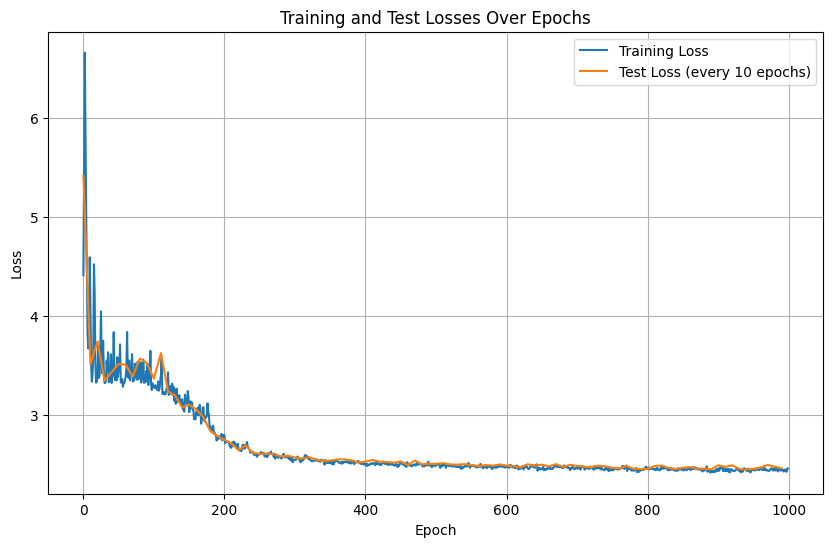

# Generated output:
```
The f hucheme uts liBumRove ainghe f my d shofathe tosh t, beis
Pormy ope shill y mo ven pus'lomy, f ots f ROfoumise bes spe t apa thttheg,
t, ch; sorite t t,
By
Bu sofadee hiswevert tt lake y tore y s isterd, a ay
Artheren til? s I mbithe IO andacodle, ho ined o ave hangb alt
Thayam. viof cage, Itoold covO tdese; a it ie f, fane, w's d on:

I tincke fuf I pincen y u, epeman gead cr bclea sthe d co wa
Ta ionuthalo.
Whatoke d huce t tl d chis m
wond o, weequearthetratFothe s h.

Serof?
BUKE thinde RW
```
# Version2: learning rate = 3e-4, 1000 epochs, using optimizer AdamW

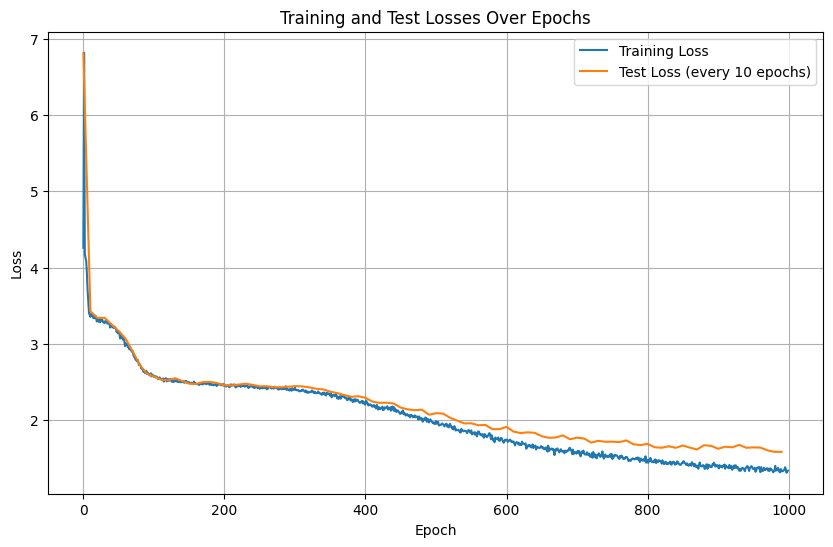



# Generated output:
```
The kaus my caate shall to heavinous come.
The curse to the tonguest place are make
Marriaginer, so drunny, and then impress of
She seem.

KING RICHARD II:
When, I can jote country, do is a vein.
Or iscounder, given Slaughber Clifford?

NORTHUMBERLAND:
Shouldst awe, being Dress eyes will came
To cold main. thy save
Eares curses to Romeo came preson,
With hate, tetimous thinder such which me
Do uncle his prettigon, dost, to must excuse.
Thy dost! Nor conside,' my lord;
And nece, busin, bless deserves

```



# Version 3: epoch = 1000 with dropout and AdamW

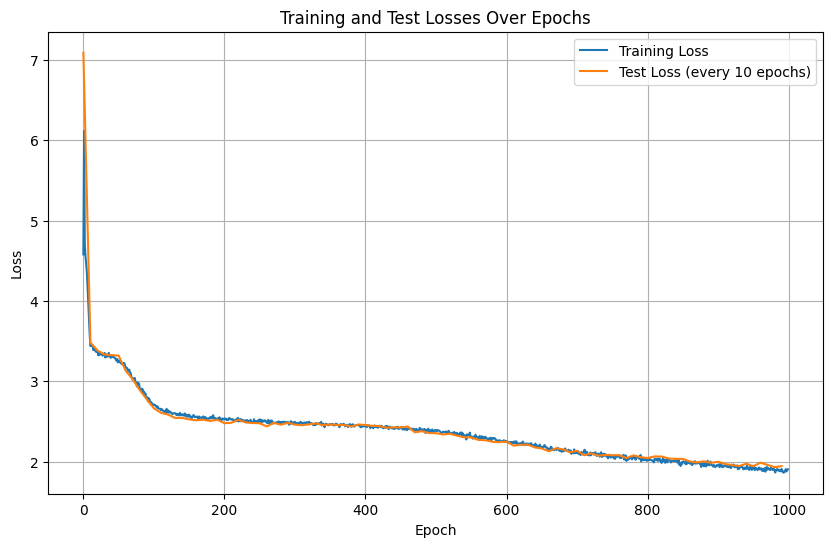

# Generated output:

```
The wes? thit your no duke cares strue.

LADY:
A shadand sriss verced-mes, not Rome you leame
Non he pisut friddy.

DUCHENS:
Sir ar prembs of But He tistaked arralle,
Tis enger. Yorg How his a wo?

Lovesice ning Cawes fargay han to worde.

DUCKEYVBRLINTA:
O, mort? telm I day prigh tortyion hion them angly, then,
Of hishow'd beall brill pener's caud thald from fates
Ward to Ento the I's harl'studs tort;
That ke be
So sogpret the re hinty whick som.
You my a sirting, so sere hinks.
Bud it betiantsine,
```





# Final version: Dropout, better hyperparameter, 5000 epochs

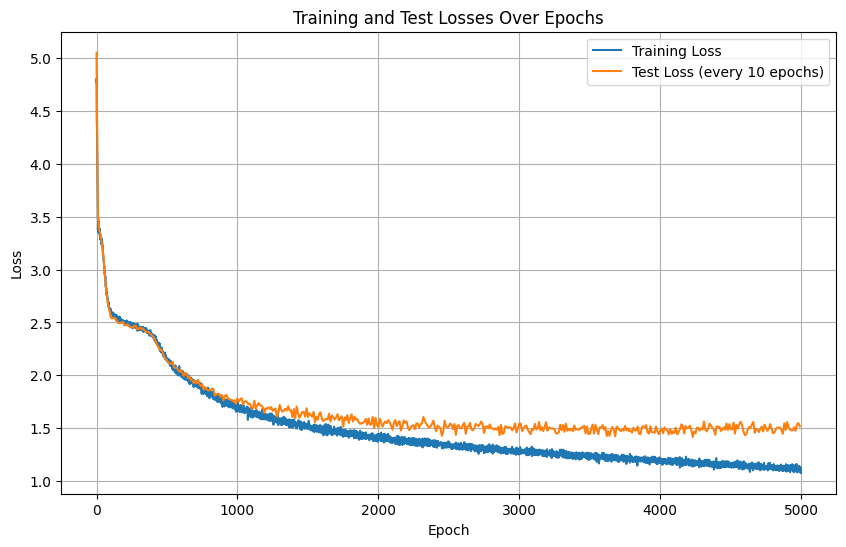



# Generated output:
```
The brother that she live-soncejoint
Your leave into his mother brick. I know, see, alree you me,
You must be not do: else you, i' duty, if
your clipps as you.

AUTOLYCUS:
As traitor, my lord's word; sudden,
I tout unltoget o' The delivery? Common neither.

Clown:
Here in thy lady slap whilst I will;
For I'll told while you woo shalt straw where you spake.

All:
While the king is in my field, withnoy?

DUKE VINCENTIO:
O, tend trade by, my poor soul!

Attempted prison, am I may under mean,
Desires my
```